# Chasing the Game

### Analyzing the impact of scoreline on scoring rates in soccer

#### Introduction
When a team is losing in soccer they are often said to be "chasing the game", implying that they are playing more aggressively in order to catch up to the other team. The trailing team therefore increases their chances of scoring a goal, while also increasing their chances of conceding a goal.

Conversely, the leading team will have some incentive to play more defensively to hold the lead, thus decreasing their chances of both scoring and conceding a goal. These competing strategies counter each other, but the net impact on scoring rates is unclear.

In order to gain some insight into this, we've performed a Markov model analysis of scoreline states in soccer games across the top 5 European domestic soccer leagues. The Markov model approach was selected as we are interested in how the scoreline impacts the rate of goal scoring for each team (i.e. not just the probability of who will score next). The Markov transition probabilities (e.g. probability for a game to go from a 0-0 scoreline to 1-0 in a certain timeframe) are representative of the scoring rates of the two teams in a given state. Thus a Markov model offers a convenient analytical approach.<sup>1</sup>


The data used for this analysis, as well as some data importing code, were accessed from:

* Pappalardo, Luca; Massucco, Emanuele (2019): Soccer match event dataset. figshare. Collection. https://doi.org/10.6084/m9.figshare.c.4415000

* Pappalardo, L., Cintia, P., Rossi, A. et al. A public data set of spatio-temporal match events in soccer competitions. Sci Data 6, 236 (2019) doi:10.1038/s41597-019-0247-7, https://www.nature.com/articles/s41597-019-0247-7

<sup>1</sup> Discussion around the applicability of the Markov property to the scoreline states is included in the Results section.

#### Preview of  results

As a preview of our results, Figure 1 below shows the estimated scoreline transition probabilities for scorelines including up to 2 goals. These transition probabilities represent the probability of transferring from a specific scoreline to another (or remaining in the same scoreline) in a ~5 minute window. The scoreline format presents home team goals on the left and away team goals on the right.

As can be observed in the figure below, it is possible for the scoreline to change by 2 goals in a ~5 minute window. Note that since we limited the figure to only showing scorelines up to 2 goals, some of the transition probabilities from a single scoreline node may not add to 1.

As we get further into our results, we will break down these results to help us understand how scoring rates for the home and away teams change based on the scoreline state. This will help us understand the impact of "chasing the game".

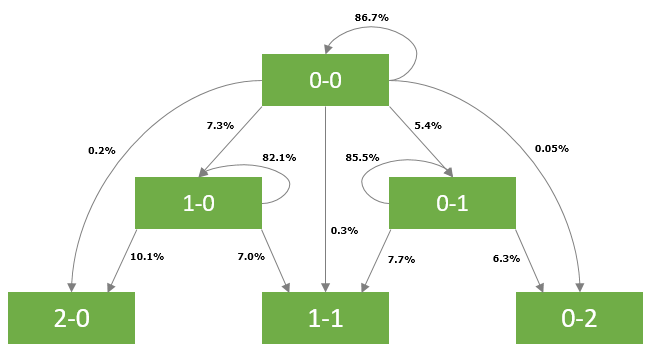
<div align="center"><b>Figure 1:</b> Transition probabilities for scorelines up to 2 goals</div>



## Importing packages

Importing necessary packages for the analysis.

In [1]:
import json
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from collections import Counter
import scipy as sp
from scipy import stats
from scipy import optimize
from scipy.integrate import quad
import transitionMatrix as tm
from transitionMatrix.estimators import cohort_estimator as es

import warnings
warnings.filterwarnings('ignore')


## Loading in data

Here we are loading in the events data from which we will pull the goal events, as well as the matches data to provide us some contextual information for the goals. 

The data used for our analysis, the *Soccer match event dataset*, is a publically available dataset containing all the spatio-temporal events (e.g, passes, shots, fouls, etc.) that take place during all matches of an entire season. The data is available for La Liga, Serie A, Bundesliga, Premier League, Ligue 1, FIFA World Cup 2018, UEFA Euro Cup 2016.

We have focused on the 5 European domestic leagues and excluded any international tournaments due to differing strategy/incentives from the different competition structure (e.g. no value for holding a draw in a knockout game).

In [2]:
events={}
nations = ['Italy','England','Germany','France','Spain']
for nation in nations:
    with open('events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)

matches={}
nations = ['Italy','England','Germany','France','Spain']
for nation in nations:
    with open('matches/matches_%s.json' %nation) as json_data:
        matches[nation] = json.load(json_data)

## Data setup

In this section we take the initial steps necessary to prepare our data for the Markov chain analysis. There are several steps needed to get to the appropriate format for the transitionMatrix package. The package had some issues for which I had to identify workarounds.

#### Identifying goals

We first pull all goal events into a separate dataframe. Both the tag for a goal and the event name are used to identify goal events. This was done as we found that the goal tag (i.e. 101), was included on some other events that were associated with a goal (e.g. a goalkeeper parry that still results in the ball going into the net).

We then show the number of goals identified from our data, which will be equivalent to the number of observed scoreline transitions.

In [3]:
event_name = 'Goal'
event_tag = 101
goal_time = []

for nation in nations:
    for ev in events[nation]:
        for i in range(len(ev['tags'])):
            if ev['tags'][i]['id'] == event_tag and ev['eventName'] == 'Shot':
                goal_time.append([ev['matchId'],ev['matchPeriod'],ev['eventSec'],ev['id'],ev['teamId'],nation])
            else:
                pass

df_goals = pd.DataFrame(goal_time, columns=['matchId','matchPeriod','eventSec','id','teamId','nation'])

print('Number of goals observed: {:.0f}'.format(len(df_goals)))

Number of goals observed: 4271


#### Inserting opening states

Here we add rows that will represent the start of the 1st and 2nd half of each game. These entries have no information aside from the matchId, half, and time, the remaining columns are filled with placeholder information indicating it is a kick-off entry. The time is set to 0 for both 1st half and 2nd half kick-offs as the times enterted in the source data for goal events are based on this structure (i.e. time restarts at 0 at the beginning of the 2nd half).

This step is necessary in order to initialize each match into the appropriate states at the outset of each half later in this notebook. Without these entries, the first state observations would be at the time the first goal is scored.

In [4]:
new_rows = []
time = 0

for i in df_goals['matchId'].unique():
    new_rows.append([i, '1H', time, '1H_kickoff','1H_kickoff','1H_kickoff'])
    new_rows.append([i, '2H', time, '2H_kickoff','2H_kickoff','2H_kickoff'])


df_new_rows = pd.DataFrame(new_rows, columns=df_goals.columns)

df_goals = df_goals.append(df_new_rows)
df_goals = df_goals.sort_values(['matchId','matchPeriod','eventSec'])
df_goals = df_goals.reset_index().drop(['index'],axis=1)

#### Goalless draws

We want to estimate transition probabilities in all games. However, because we have set up our data base on goal events, we now need to add in all goalless draws, which won't be captured in the goal events data.

In order to do this we search the matches dataset and identify all matchIds for games in which neither team scored any goals. We then insert first half and second half kickoff entries for these games in the 0-0 state. Our analysis will then consider these games as being in the 0-0 state for the full duration of both halves.

In [5]:
goalless_draws = []
time=0

for nation in nations:
    for ma in matches[nation]:
        team_1_goals = ma['teamsData'][list(ma['teamsData'])[0]]['score']
        team_2_goals = ma['teamsData'][list(ma['teamsData'])[1]]['score']
        if team_1_goals == 0 and team_2_goals == 0:
            goalless_draws.append([ma['wyId'],'1H',time, '1H_kickoff','1H_kickoff','1H_kickoff'])
            goalless_draws.append([ma['wyId'],'2H',time, '2H_kickoff','2H_kickoff','2H_kickoff'])
            
df_GD = pd.DataFrame(goalless_draws, columns=df_goals.columns)

df_goals = df_goals.append(df_GD)
df_goals = df_goals.sort_values(['matchId','matchPeriod','eventSec'])
df_goals = df_goals.reset_index().drop(['index'],axis=1)

#### Identifying which team scored

We are going to organize our goals data based on home goals and away goals. The first step is to identify whether each goal was scored by the home team or the away team. We use the matches dataset to help identify whether the team that scored each goal was the home side or away side. For the kickoff rows we simply carry through the placeholder information (i.e. 1H_kickoff or 2H_kickoff) into this column.

In [6]:
df_goals['homeaway'] = np.nan

for i in range(len(df_goals)):  
    if df_goals.loc[i,'teamId'] == '1H_kickoff' or df_goals.loc[i,'teamId'] == '2H_kickoff':
        df_goals.loc[i,'homeaway'] = df_goals.loc[i,'teamId']
    else:
        mID = df_goals.loc[i,'matchId']
        tID = str(df_goals.loc[i,'teamId'])
        nation = df_goals.loc[i,'nation']
        df_goals.loc[i,'homeaway'] = next(item for item in matches[nation] if item["wyId"] == mID)['teamsData'][tID]['side']

#### Compiling match scores

We now identify the resulting scoreline from each goal event in our dataset by going through the data and adding the home and away goals in each match sequentially. The process restarts at 0-0 once we reach a new game (i.e. when a first half kick-off is reached). Second half kick-offs simply inherit the most recent scoreline from that game's first half.

In [7]:
# Initializing variables to count the number of home goals and away goals in a game after each goal event.

df_goals['home_goals'] = np.zeros(len(df_goals), dtype='int32')
df_goals['away_goals'] = np.zeros(len(df_goals), dtype='int32')

for i in range(len(df_goals)):
    if i == 0:
        if df_goals.loc[i,'homeaway'] == 'home':
            df_goals.loc[i,'home_goals'] += 1
        elif df_goals.loc[i,'homeaway'] == 'away':
            df_goals.loc[i,'away_goals'] += 1
    else:
        if df_goals.loc[i,'homeaway'] == '1H_kickoff':
            df_goals.loc[i,'home_goals'] = 0
            df_goals.loc[i,'away_goals'] = 0
        elif df_goals.loc[i,'homeaway'] == '2H_kickoff':
            df_goals.loc[i,'home_goals'] = df_goals.loc[i-1,'home_goals']
            df_goals.loc[i,'away_goals'] = df_goals.loc[i-1,'away_goals']
        else:        
            if df_goals.loc[i,'homeaway'] == 'home':
                df_goals.loc[i,'home_goals'] = df_goals.loc[i-1,'home_goals']+1
                df_goals.loc[i,'away_goals'] = df_goals.loc[i-1,'away_goals']
            elif df_goals.loc[i,'homeaway'] == 'away':
                df_goals.loc[i,'away_goals'] = df_goals.loc[i-1,'away_goals']+1
                df_goals.loc[i,'home_goals'] = df_goals.loc[i-1,'home_goals']
    
# Creating our scoreline format to help set-up the state space later.
    
df_goals['score'] = df_goals['home_goals'].astype(str)+'-'+df_goals['away_goals'].astype(str)

#### Creating halfIds

We next create 'halfIds' by appending the matchId with the half indicator (i.e. 'matchPeriod'), producing unique Ids for each half in the dataset. This is done as we will treat each half as an individual match. For the second halves, these 'matches' will be starting in whichever state that game's 1st half ended.

This step is taken for a number of reasons, in part due to the structure of the goal events data and the uncertainty around the time of the first half's conclusion. This approach may introduce some noise to our analysis. In future versions we will look to "stitch" together the halves by using the end time of the first half and modifying the timestamps of the 2nd half goals accordingly.

In [8]:
df_goals['halfId'] = df_goals['matchId'].astype(str)+df_goals['matchPeriod']

## Creating the state space

In the following section we create and apply the state space to our goal events.

We first create our state space by identifying the maximum # of goals scored in our data (7), and then creating all possible scorelines with an associated state number in a dictionary, all the way up to 7-7. Away goals only go up to 5 in our data, but we will keep it symmetric.

In [9]:
max_goals = np.maximum(df_goals['home_goals'].max(),df_goals['away_goals'].max())

# Use the following for loop to generate the set of possible state spaces

states = []
counter = 0
for i in range(max_goals + 1):
    for j in range(max_goals + 1):
        states.append((str(counter),str(i)+'-'+str(j)))
        counter += 1
        
myState = tm.StateSpace(states)

#### Applying the state space

Here we apply the state space to the data by creating a new column that copies the scoreline, and we then replace the entries in this column with the associated state space number in the dictionary we created.

In [10]:
state_dict = {}
for i in range(len(states)):
    state_dict[states[i][1]]=states[i][0]

df_goals['state'] = df_goals['score']    
df_goals = df_goals.replace({'state': state_dict})

## Estimating transition probabilities

In this section we now work towards the actual estimation of transition probabilities. There are a few final steps of data processing in which we will create a new dataframe and manipulate our data to conform with the transitionMatrix package's requirements. As mentioned previously, there are some issues using the package for which we've had to find workaround solutions.

We also validate our state space against the data to confirm they are consistent. As shown below there are more states in our state space than are observed in the data since not every scoreline is present. This is not an issue for the analysis.

In [11]:
df_goals_new = df_goals.drop(columns=['matchPeriod','id','teamId','homeaway','home_goals',
                                      'away_goals','score','matchId','nation'])
df_goals_new = df_goals_new.rename(columns={'halfId':'ID','eventSec':'Time','state':'State'})
df_goals_new = df_goals_new.reset_index().drop(['index'],axis=1)

# We need to rearrange the order of the coumns here as we found that the transitionMatrix package doesn't function otherwise.

df_goals_new = df_goals_new[['ID','Time','State']]

print(myState.validate_dataset(dataset=df_goals_new))

['0', '8', '9', '10', '18', '19', '27', '35', '1', '2', '3', '11', '16', '24', '32', '17', '26', '4', '25', '40', '5', '33', '41', '49', '57', '34', '12', '20', '21', '42', '28', '36', '13', '48', '50', '51', '22', '29', '30', '43', '56']
('Dataset contains fewer states than expected. Check the following: ', {'61', '58', '15', '59', '23', '55', '60', '45', '63', '46', '14', '38', '39', '52', '54', '6', '47', '62', '53', '31', '37', '44', '7'})


#### Adapting halfIds

Here we need to move our halfIds into standard integer IDs (i.e. 0,1,2,...). This was identified as an issue based on a review of the transitionMatrix code, which isn't set up to process Ids in either the matchIds or the halfIds format.

The method used here is to generate a list of the unique halfIds and then assign the new integer IDs based on the halfIds location in the unique list.

In [12]:
half_ids_unique = df_goals['halfId'].unique().tolist()

for i in range(len(df_goals_new)):
    mID = df_goals_new.loc[i,'ID']
    df_goals_new.loc[i,'ID'] = half_ids_unique.index(mID)

#### Binning the data

Our data is now properly set-up to use the transitionMatrix package's binning function which will discretize our state observations and in-fill intermediate states between transition events. We have binned the match halves into 9 time frames (also referred to as "periods" throughout this notebook), which is equiavelent to a little more than 5 minutes each.

Increasing the resolution too high for the periods will lead to very low and unreliable transition probabilities, while too coarse of a representation will provide less insight into the scoreline transitions.

In [13]:
binned_data, bin_intervals = tm.utils.bin_timestamps(df_goals_new, cohorts=9)

Unfortunately the binning functionality doesn't properly maintain the state space structure of our input data.

Because the binning function preserves the event time of the last transition and the IDs, my workaround for this was to do a merge with the input dataframe, joined on the times and IDs, and then using the states brought from our original dataframe to replace the cohort states.

In [14]:
binned_data['State'] = binned_data.merge(df_goals_new, left_on=['ID','EventTime'], right_on=['ID','Time'])['State_y']

#### Estimating the transition probabilities

We can now put our data into the estimator from the transitionMatrix package and get our results.

In [15]:
myEstimator = es.CohortEstimator(states=myState, ci={'method': 'goodman', 'alpha': 0.05})
labels = {'Timestamp': 'Cohort', 'State': 'State', 'ID': 'ID'}
result = myEstimator.fit(binned_data, labels=labels)

## Results

We can now analyze our results. In our anaysis, we cannot represent the matrix of transition probabilities in an insightful way as there isn't an intuitive way to lay out the possible scorelines.

Therefore, to better present our results we create a function that will allow us to identify the transition probability from any specific scoreline to another scoreline. The function looks up the scoreline in the state space dictionary so that we do not need to consider the state space labels.

In [16]:
def t_prob(a,b):
    return result[0][int(state_dict[a])][int(state_dict[b])]

The function is used to calculate some preliminary results below. Note that these probabilities don't add to 100% due to the possibility of 2-goal transitions, which will be shown subsequently.

In [17]:
print("Probability home team scores first goal in next ~5 minutes:  {:.1%}".format(t_prob('0-0','1-0')))
print("Probability away team scores first goal in next ~5 minutes:  {:.1%}".format(t_prob('0-0','0-1')))
print("Probability score remains 0-0 in the next ~5 minutes:        {:.1%}".format(t_prob('0-0','0-0')))

Probability home team scores first goal in next ~5 minutes:  7.3%
Probability away team scores first goal in next ~5 minutes:  5.4%
Probability score remains 0-0 in the next ~5 minutes:        86.7%


#### 1-Period transition probabilities from 0-0

We first analyzed the transition probabilities from 0-0 in a single period. Based on the data, we have observed transitions from 0-0 to 1-0, 0-1, 2-0, 0-2, or 1-1 in a single period. We've presented the 1-period transition probabilities from a 0-0 scoreline in Figure 2 below. As expected the home team is generally more likely to score.

Interestingly, the probability of the home team going 2-0 up in a single period is 4x higher than it is for the away team to go up 0-2. This may be the result of away teams being overwhelmed by the home crowd pressure after conceding a first goal.

The jump to 1-1 is also significantly higher than the 2-0 and 0-2 probabilities. This may be a result of teams scoring first, losing focus, and then conceding shortly afterwards, which would be consistent with some of the conventional wisdom in soccer (or sports in general).

It should be kept in mind that the 2-goal transitions are rare events and therefore these estimates are more variable.

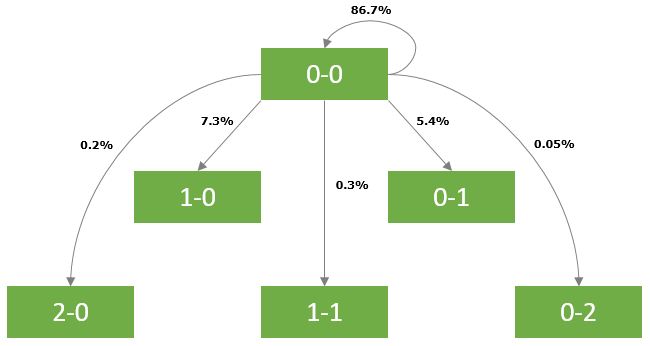
<div align="center"><b>Figure 2:</b> One-period transitions from 0-0 estimated from our data</div>

#### Transition probabilities after the first goal is scored

We next looked at the transition probabilities after one of the teams has opened the scoring (i.e. from either a 1-0 or 0-1 scoreline). For brevity we have only presented the one-goal transition probabilities.

We see again the home team has a higher likelihood of scoring compared to an away team in a similar situation (i.e. either leading or trailing 1-0 / 0-1).

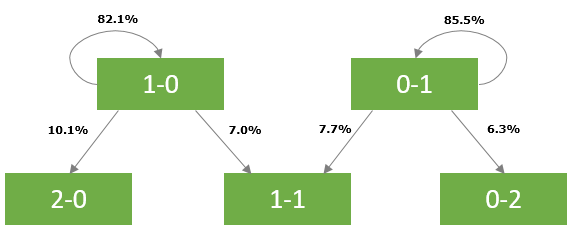

<div align="center"><b>Figure 3:</b> One-period/one-goal transitions from 1-0 and 0-1</div>

#### Impact of scoreline on scoring rates

We now want to discuss the initial aim of this exercise, to understand how teams' scoring probabilities shift when the scoreline changes, and how the situation of one team "chasing the game" affects the probabilities of each team scoring.

As discussed in the opening of this notebook, we want to know the net impact on scoring rates for the leading and trailing teams after a team has taken the lead. Therefore, we now calculate some ratios to demonstrate the changes in scoring rates for the home and away teams when they are up or down 1-0 or 0-1, compared to the baseline scoring rates at 0-0.

For purposes of the last discussion we have removed the double goal outcomes and stationary probabilities to simplify the illustration.

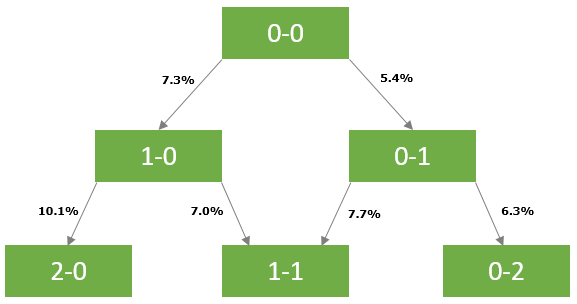

<div align="center"><b>Figure 4:</b> One-period/one-goal transitions for 0-0, 0-1, and 1-0</div>

Based on the figure above we calculate the relative change in transition probabilities in each of the 4 possible (one-goal) events at 1-0 and 0-1 scorelines relative to the corresponding baseline transition probabilities in the 0-0 scenario.

In [18]:
print('1: {:.3}'.format(t_prob('1-0','2-0')/t_prob('0-0','1-0')))
print('2: {:.3}'.format(t_prob('1-0','1-1')/t_prob('0-0','0-1')))
print('3: {:.3}'.format(t_prob('0-1','1-1')/t_prob('0-0','1-0')))
print('4: {:.3}'.format(t_prob('0-1','0-2')/t_prob('0-0','0-1')))

1: 1.38
2: 1.3
3: 1.05
4: 1.16


We present the mathematical representation of these results below. The phrases "Home scores" or "Away scores" are used for simplicity. These phrases specifically mean that the respective team scores in a given period, without any other goals being scored. 

$\large{\frac{\text{Pr}(\text{Home scores} \, | \, 1\text{-}0)}{\text{Pr}(\text{Home scores} \, | \, 0\text{-}0)}} \normalsize{\, = 1.38}$

$\large{\frac{\text{Pr}(\text{Away scores} \, | \, 1\text{-}0)}{\text{Pr}(\text{Away scores} \, | \, 0\text{-}0)}} \normalsize{\, = 1.30}$

$\large{\frac{\text{Pr}(\text{Home scores} \, | \, 0\text{-}1)}{\text{Pr}(\text{Home scores} \, | \, 0\text{-}0)}} \normalsize{\, = 1.05}$

$\large{\frac{\text{Pr}(\text{Away scores} \, | \, 0\text{-}1)}{\text{Pr}(\text{Away scores} \, | \, 0\text{-}0)}} \normalsize{\, = 1.16}$

#### Changes in scoring rates

When the home team goes up first, the scoring rates increase by a factor of 1.38 for the home team and 1.30 for the away team. In the case where the away team goes up 0-1, we see that the scoring rate for the home team changes by a factor of 1.05 and the away scoring rate changes by a factor of 1.16. 

After the first goal is scored, the scoring rates for both teams increase. In both cases, the team that takes the lead has a greater increase in their scoring rate relative to the trailing team. Therefore, these results generally show that once a team is chasing the game they increase their scoring rate, however they increase their chance of conceding by a greater amount. Nonetheless, this still remains an optimal strategy given there are very minimal consequences from conceding further goals when a team is already in a losing position.

The results also show that this effect is much more pronounced in the case when the home team takes the lead. Therefore, neutral spectators may want the home team to score first if they are hoping for an entertaining game!

#### Confounding

One note to consider with these results is that there is likely some confounding. In particular, the team that has taken the lead will often be the better team, and the transition probabilities from 1-0 and 0-1 will capture this information. The magnitude of this confounding is unclear. However, given we are only analyzing matches between teams in the same leagues, the average disparity between teams will be relatively contained. One approach to controlling for this could be to factor in the relative attacking and defensive strengths of the teams in our dataset.

In regards to the above results, controlling for this confounding will increase the change in scoring rates of the team that has gone down and decrease the change in scoring rates of the team that has gone up. We expect the average change in scoring rates across the two teams to remain stable in each case after accounting for the confounding.

#### Markov property

Another factor to consider is whether the process we have modelled satisfies the Markov property (i.e. is memoryless).

Consider a scoreline at 3-3. The momentum of this scoreline will likely depend on how it was reached. Consider for example if the game has gone back and forth with teams alternating scoring goals. Next consider a scoreline in which one team reached a 3-0 lead, followed by the other team mounting a comeback to reach a 3-3 scoreline. In the latter case the momentum of the situation may affect the scoring rates of the two teams relative to the former case. This could potentially be controlled for by modelling the sequence of scorelines as the states instead of the current scoreline, however this would limit the analysis and require more data for reliable results.

All the states up to 2 goals will not have this problem. For example, the transition probabilities from 1-0 to 2-0 or 1-1 only considers the change in scoreline from 0-0 to 1-0, which is the current state. No information is gained from the fact this scoreline started at 0-0 as that is only preceding state possible. As such we can conclude that these transition probabilities analyzed above are in fact memoryless. If we extend our analysis to 3 goal scorelines such as 2-1, 1-2, we may start to see the impact of the pattern in which those goals were scored. We could also analyze scorelines such as 3-0/0-3, 4-0/0-4, etc. as well, as these scorelines would also have the Markov property. However the confounding discussed above would be elevated in these cases.

## Next steps

#### Predicting scorelines with dynamic scoring rates

An interesting application of this would be to look at the impact of dynamic scoring rates on the predicted probability distribution of scoreline outcomes. Many simulations assume each team's goals are distributed based on a Poisson distribution with a fixed scoring rate. A simulation with dynamic scoring rates may ultimately lead to different results when assessing the likelihood of certain scorelines. In particular, this would lead to significantly different predictions compared to a standard model when predicting the final scoreline after a goal has already been scored in the game.

#### Scoreline impact on spatial-distribution of events

Another direction of analysis I would like to take is to analyze the impact of the scoreline on the spatial distribution of events (e.g. passes, tackles). Specifically, how do these distributions change for the leading and trailing teams relative to a baseline distribution. We expect the team chasing the game will be pushed up the field more, and vice versa for the leading team, resulting in shifted event distributions.

In the same vein, an analysis of the types of pass events for the trailing team may prove an interesting analysis. In particular, teams chasing the game will often play more directly towards the opposition's box. Validating this understanding in the data would be an interesting exercise.

***Update***: *Please see the added notebook exploring spatial distribution of passes in different scoreline scenarios.*

#### Controlling confounding

An extension of this analysis would be to find a way to control for the strength of the teams playing in the goals data, in order to remove any potential confounding in the results. This would require incorporating some data on the offensive and defensive capabilities of the teams in our dataset.

**That's all for now, thanks for reading!**